TODO:<br>
affine transformations for shear, rotate, shift, zoom, flip

In [1]:
%%writefile './lib/generator.py'
# -------------------------------------------------------------------------------------------------------------------------------
import tensorflow as tf
# fetch GPU device name
GPU = tf.config.list_logical_devices('GPU')[0].name

class multiGen(tf.keras.utils.Sequence):
    """Image Data Generator for multi-output models    
    --------------------------------------------
    a typical tensorflow ImageDataGenerator does not suit the purpose as it cannot map multiple output
    also the same cannot perform custom augmentations that include transformations for bounding boxes
    """
    def __init__(self,train,test,imagePath,className,bBox,
                 input_size,target_size,batch_size,normalize=True,
                 validation_split=None,seed=100,initial_epoch=None):
        """arguments:
        ----------
        train : dataframe of training dataset
        test : dataframe of training dataset
            (note:both train & test dataframes to be of same structure)
        imagePath : column name contaning path of images
        className : column name containing true class names
        bBox : list of columns containing bounding box coordinates [x1,y1,x2,y2]
        input_size : list of columns containing width & height of images
        target_size : expected size of image output, typically the input size of network that consumes the image
        batch_size : number of images to process for each batch of output
        normalize : boolean to opt for normalize or not
        validation_split : ratio of validation vs training split
        seed : random consistency seed
        initial_epoch : used for retraining a model, to resume from an epoch
        """
        from sklearn.preprocessing import LabelBinarizer
        
        super(multiGen,self).__init__()
        
        self.target_size = target_size
        self.batch_size = batch_size
        self.vSplit = validation_split
        self.seed = seed        
        self.train = train.copy()
        self.test = test.copy()
        self.epoch = initial_epoch
        self.normalize = normalize
        
        # train, test & vaidation set allocation
        if self.vSplit == None:
            self.__noSplit(imagePath,className,bBox,input_size)
        else:
            self.__split(imagePath,className,bBox,input_size)
            
        # evaluation set allocations
        self.__evalPrep(imagePath,className,bBox,input_size)
            
        # class encoder
        self.enc = LabelBinarizer().fit(self.trClassName.values)
        
        # generator setup completion flag
        self.GENERATE = False
        self.AUGMENT = True
        
    def __noSplit(self,imagePath,className,bBox,input_size):
        """private helper function"""
        # shuffle training set alone
        trdf = self.train.sample(frac=1,random_state=self.seed).reset_index(drop=True)
        # X inputs
        self.trImagePath,self.ttImagePath = trdf[imagePath],self.test[imagePath]
        # Y class outputs
        self.trClassName, self.ttClassName= trdf[className],self.test[className]
        # Y bBox outputs
        self.trbBox,self.ttbBox = trdf[bBox],self.test[bBox]
        # width & height of original images
        self.triSize,self.ttiSize = trdf[input_size],self.test[input_size]
        
    def __evalPrep(self,imagePath,className,bBox,input_size):
        """private helper function"""
        # X inputs
        self.evalTrImagePath,self.evalTtImagePath = self.train[imagePath],self.test[imagePath]
        # Y class outputs
        self.evalTrClassName, self.evalTtClassName= self.train[className],self.test[className]
        # Y bBox outputs
        self.evalTrbBox,self.evalTtbBox = self.train[bBox],self.test[bBox]
        # width & height of original images
        self.evalTriSize,self.evalTtiSize = self.train[input_size],self.test[input_size]
        
    def __split(self,imagePath,className,bBox,input_size):  
        """private helper function"""
        import numpy as np
        # random index split
        np.random.seed(self.seed)
        index = np.random.choice(self.train.index,size=self.train.shape[0],replace=False)
        trIndex = index[:-int(self.train.shape[0]*self.vSplit)]
        vIndex = index[-int(self.train.shape[0]*self.vSplit):]
        trdf = self.train.loc[trIndex].reset_index(drop=True,inplace=False)
        vdf = self.train.loc[vIndex].reset_index(drop=True,inplace=False)
        # X inputs
        self.trImagePath,self.vImagePath,self.ttImagePath = trdf[imagePath],vdf[imagePath],self.test[imagePath]
        # Y class outputs
        self.trClassName,self.vClassName,self.ttClassName = trdf[className],vdf[className],self.test[className]
        # Y bBox outputs
        self.trbBox,self.vbBox,self.ttbBox = trdf[bBox],vdf[bBox],self.test[bBox]
        # width & height of original images
        self.triSize,self.viSize,self.ttiSize = trdf[input_size],vdf[input_size],self.test[input_size]
        
    def subset(self,subset_name,verbose=0):
        """ creates deepcopy of the multiGen instance, orienting the generator towards requested subset
        arguments:
        ----------
        subset_name : one of 'training','validation','testing','evaluation on trainset', 'evaluation on testset'
        
        returns : a deepcopy of the current instance, prepared for generation
        """
        from copy import deepcopy
        objCopy = deepcopy(self) # create a copy of the generator instance
        # set output data
        if subset_name == "training":
            objCopy.imPath,objCopy.cName,objCopy.bBox,objCopy.iSize = objCopy.trImagePath.values.copy(),objCopy.trClassName.values.copy(),objCopy.trbBox.values.copy(),objCopy.triSize.values.copy()
        elif subset_name == "validation":
            objCopy.imPath,objCopy.cName,objCopy.bBox,objCopy.iSize = objCopy.vImagePath.values.copy(),objCopy.vClassName.values.copy(),objCopy.vbBox.values.copy(),objCopy.viSize.values.copy()
        elif subset_name == 'testing':
            objCopy.imPath,objCopy.cName,objCopy.bBox,objCopy.iSize = objCopy.ttImagePath.values.copy(),objCopy.ttClassName.values.copy(),objCopy.ttbBox.values.copy(),objCopy.ttiSize.values.copy()
        elif subset_name == 'evaluation on trainset' :
            objCopy.imPath,objCopy.cName,objCopy.bBox,objCopy.iSize = objCopy.evalTrImagePath.values.copy(),objCopy.evalTrClassName.values.copy(),objCopy.evalTrbBox.values.copy(),objCopy.evalTriSize.values.copy()
            self.AUGMENT = False # no image augmentation techniques while evaluation
        elif subset_name == 'evaluation on testset' :
            objCopy.imPath,objCopy.cName,objCopy.bBox,objCopy.iSize = objCopy.evalTtImagePath.values.copy(),objCopy.evalTtClassName.values.copy(),objCopy.evalTtbBox.values.copy(),objCopy.evalTtiSize.values.copy()
            self.AUGMENT = False # no image augmentation techniques while evaluation
        else:
            raise ValueError("unknown subset request: %s"%subset_name)
        # update length data
        objCopy.nSteps = (objCopy.bBox.shape[0] // objCopy.batch_size)
        # delete unnecessary data within the object
        del objCopy.train,objCopy.test,
        del objCopy.trImagePath,objCopy.trClassName,objCopy.trbBox,objCopy.triSize
        del objCopy.ttImagePath,objCopy.ttClassName,objCopy.ttbBox,objCopy.ttiSize
        del objCopy.evalTrImagePath,objCopy.evalTrClassName,objCopy.evalTrbBox,objCopy.evalTriSize
        del objCopy.evalTtImagePath,objCopy.evalTtClassName,objCopy.evalTtbBox,objCopy.evalTtiSize
        if objCopy.vSplit != None:
            del objCopy.vImagePath,objCopy.vClassName,objCopy.vbBox,objCopy.viSize
        # labelencode names
        objCopy.cName = objCopy.enc.transform(objCopy.cName).astype(float)        
        # set the generator as ready
        objCopy.lastIndex = 0
        objCopy.GENERATE = True
        # print
        if verbose:
            print("registered %d images serving %d steps for %s"%(objCopy.bBox.shape[0],objCopy.nSteps,subset_name))
        return objCopy # return the modified generator
    
    def on_epoch_end(self):
        """ override Sequence class method
        shuffles dataset after each epoch
        consistent shuffling using randomizer seed
        """
        import numpy as np
        if self.epoch == None:
            self.epoch = 0
        if self.AUGMENT:
            np.random.seed(self.seed+self.epoch)
            index = np.random.choice(range(self.bBox.shape[0]),self.bBox.shape[0],replace=False)
            self.imPath,self.cName,self.bBox,self.iSize = self.imPath[index],self.cName[index],self.bBox[index],self.iSize[index]
        self.epoch+=1
        super().on_epoch_end()
        
    def __len__(self):
        """override Sequence class method
        returns number of steps per epoch
        """
        return self.nSteps
    
    def __getitem__(self,step):
        """ generate a batch of data
        arguments:
        ----------
        step : current step/batch number
        
        returns:
        --------
        independant variables X & true target variables Y
        """
        import numpy as np        
        index = np.arange(step*self.batch_size,min((step+1)*self.batch_size,self.bBox.shape[0]))        
        X,Y = self.fetchBatch(index)
        self.lastIndex = (step+1)*self.batch_size if (step+1)*self.batch_size<self.bBox.shape[0] else 0
        return X,Y
    
    def next(self):
        """generate next batch
        returns:
        --------
        independant variables X & true target variables Y
        """
        import numpy as np        
        index = np.arange(self.lastIndex,min(self.lastIndex+self.batch_size,self.bBox.shape[0]))
        X,Y = self.fetchBatch(index)
        self.lastIndex = self.lastIndex+self.batch_size if self.lastIndex+self.batch_size<self.bBox.shape[0] else 0
        return X,Y 

Overwriting ./lib/generator.py


In [2]:
%%writefile -a './lib/generator.py'
# -------------------------------------------------------------------------------------------------------------------------------
def fetchBatch(self,index):
    """ prepares a batch of images, names and bounding boxes
    arguments:
    ----------
    index : index of datapoints to feed to the current batch
    
    returns:
    --------
    X,Y as (array of images) and tupple of (names and bounding box coordinates)
    """
    import numpy as np
    import tensorflow as tf

    if self.GENERATE == False:
        raise NotImplementedError("subsets not defined, instead generator request received")
    
    # normalisation factor
    scale = 255.0 if self.normalize else 1.0
    
    # fetch images, convert to arrays, and resize to target size, normalize & compile as a tensor
    with tf.device(GPU):
        tkpi = tf.keras.preprocessing.image
        ti = tf.image
        
        images = tf.convert_to_tensor([ti.resize(tkpi.img_to_array(tkpi.load_img(image)),
                                                 self.target_size,
                                                 antialias=True)/scale for image in self.imPath[index]])
    
    # obtain encoded class logits as tensors
    names = tf.convert_to_tensor(self.cName[index])     
    
    # fetch bounding box coordinates & resize to meet target size
    boxes = self.bBox[index]
    sizes = self.iSize[index]
    sizes = np.append(sizes,sizes,axis=1)
    with tf.device(GPU):
        boxes = tf.divide(boxes,sizes)
    
    return images,tuple((names,boxes))  

multiGen.fetchBatch = fetchBatch
    
def __display3(self,images,boxes,names):
    """display 3 images in a subplot
    arguments:
    ----------
    images : array of images as array (None,:,:,3)
    boxes : array of bounding box coordinates (None,4)
    names : array of class names (None,4)
    
    functions:
    displays a subplot of images with bounding boxes augmented
    x & y scales will be displayed to refer dimensions
    class name will be titled to the subplots
    """
    import tensorflow as tf
    import cv2
    import matplotlib.pyplot as plt

    im = images.copy()   
    tkpi = tf.keras.preprocessing.image
    plt.figure(figsize=(16,5))
    for i in range(0,3):
        ax = plt.subplot(1,3,i+1)
        image = im[i]
        cv2.rectangle(image,boxes[i][:2],boxes[i][2:],(0,0,255),2)
        image = tkpi.array_to_img(image)
        plt.imshow(image)
        plt.title(names[i])
    plt.show();

multiGen.__display3 = __display3
    
def compare3(self,predictions=None):
    """generate a batch of 3 images, and compare with original images"""
    import numpy as np
    import tensorflow as tf
    import cv2
    
    if predictions!=None:
        predIndex = np.random.choice(np.arange(len(predictions.get('index'))),3,replace=False)
        index = predictions.get('index')[predIndex]
    else:
        index = np.random.choice(range(self.bBox.shape[0]),3,replace=False)
    
    tkpi = tf.keras.preprocessing.image
    images = np.asarray([tkpi.img_to_array(tkpi.load_img(image)) for image in self.imPath[index]],dtype=object)
    boxes = self.bBox[index]
    names = self.enc.inverse_transform(self.cName[index])
    sizes = self.iSize[index]

    print("Original images with bounding boxes")
    self.__display3(images,boxes,names)

    # resize
    inputDims = np.append(sizes,sizes,axis=1)
    reBoxes = np.divide(boxes,inputDims)
    oSize = np.array(self.target_size*len(images)).reshape(-1,2)
    oSize = np.append(oSize,oSize,axis=1)
    reBoxes = np.multiply(reBoxes,oSize).astype(int)
    reImages = np.array([cv2.resize(image,self.target_size) for image in images])
    print("Transformed images with bounding boxes")
    self.__display3(reImages,reBoxes,names)
    
    if predictions==None:
        return
    
    # inverseGen
    predBoxes = predictions.get('boxes')[predIndex]
    predNames = predictions.get('names')[predIndex]
    predBoxes = self.unSize(predBoxes,index)
    predNames = self.unCode(predNames)
    print("Original images with Predicted bounding boxes & names")
    self.__display3(images,predBoxes,predNames)

multiGen.compare3 = compare3

def unSize(self,boxes,index):
    """scale the predicted bounding boxes to suit original images sizes
        arguments:
        ----------
        boxes : array of predicted bounding box coordinates (None,4)
        index : index of original image used for prediction

        returns:
        --------
        boxes : array of bounding box coordinates mapped to original images sizes (None,4)
        """
    import numpy as np
    # expected original size map
    oSize = np.append(self.iSize[index],self.iSize[index],axis=1)
    boxes = np.multiply(boxes,oSize).astype(int)
    return boxes

multiGen.unSize = unSize

def unCode(self,names):
    """decode the predicted names
        arguments:
        ----------
        names : array of predicted class names as predict_proba output

        returns:
        --------
        names : decoded names in strings
        """
    return self.enc.inverse_transform(names,threshold=0.5)  

multiGen.unCode = unCode

Appending to ./lib/generator.py


In [3]:
from lib.extract import trainDF,testDF
from lib.generator import multiGen

imScanTest: 100%|█████████████████████████████| 196/196 [00:05<00:00, 34.99it/s]
2022-07-28 23:14:49.451607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 23:14:49.476821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 23:14:49.476973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 23:14:49.477626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable


test #1: Instance Assertion passed
test #2: __getitem__() Output shape passed
test #3: next() Output shape passed
test #4: __len__() implemented

Original images with bounding boxes


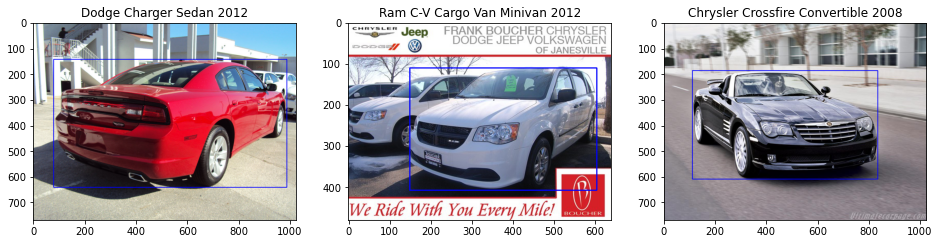

Transformed images with bounding boxes


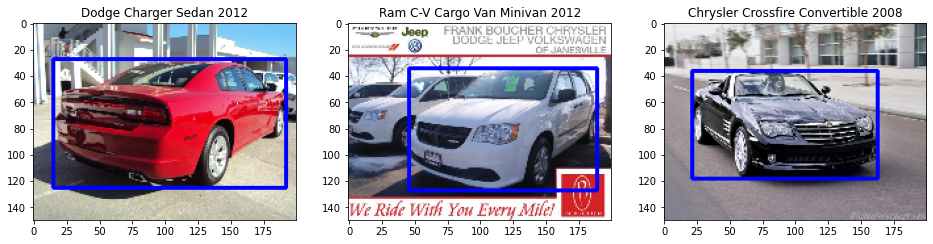

Original images with bounding boxes


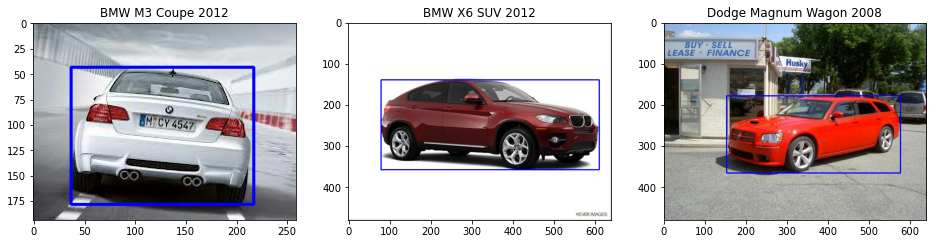

Transformed images with bounding boxes


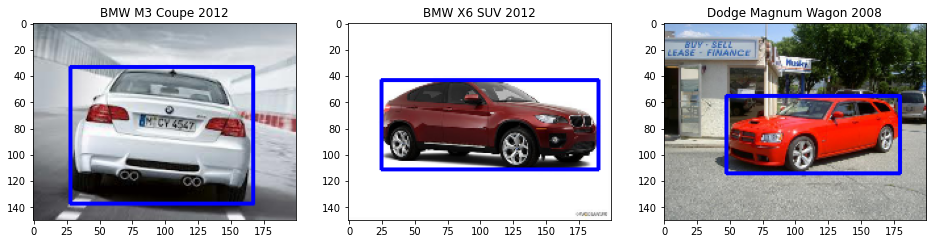

Original images with bounding boxes


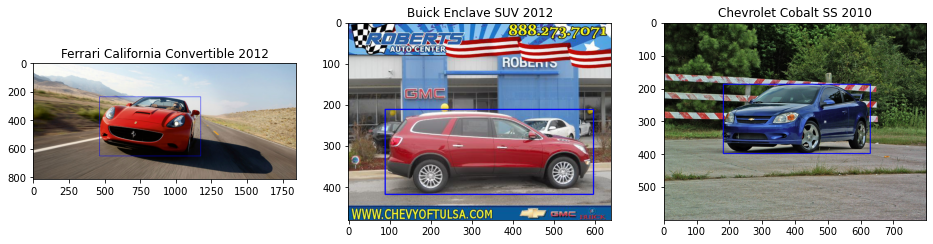

Transformed images with bounding boxes


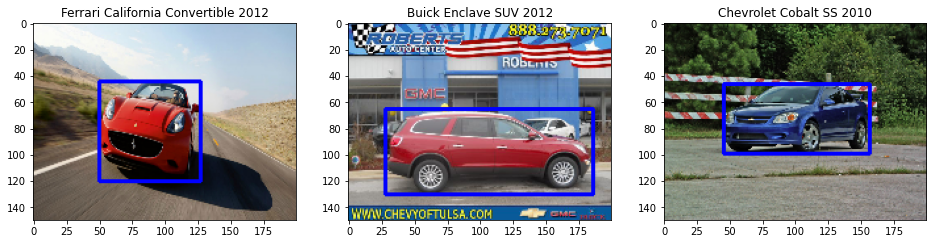

Original images with bounding boxes


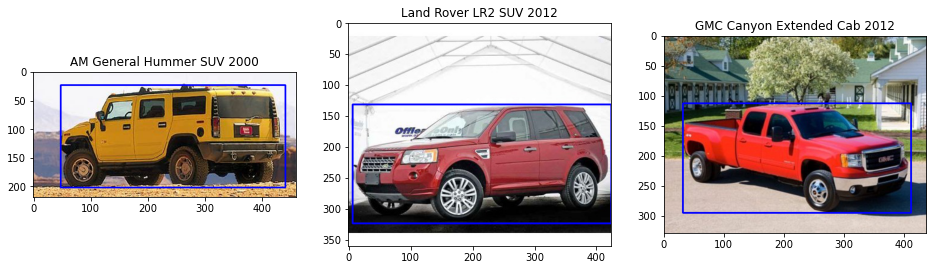

Transformed images with bounding boxes


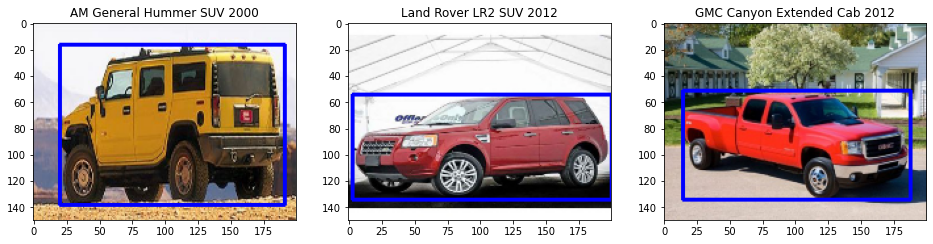

Original images with bounding boxes


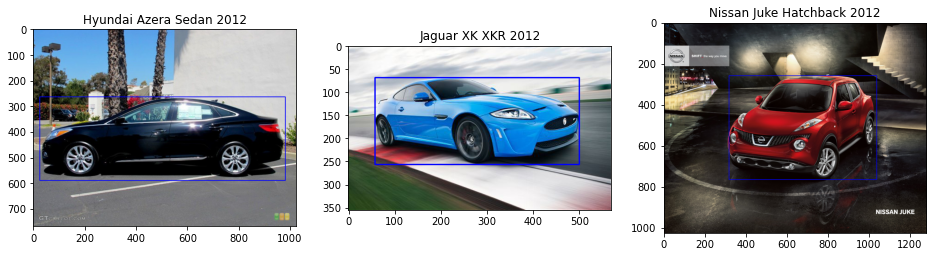

Transformed images with bounding boxes


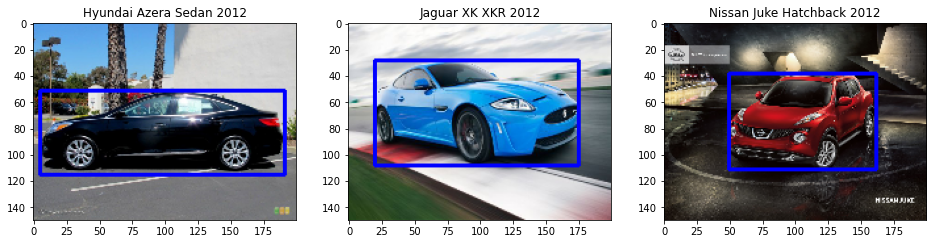

In [4]:
# generator implementation
gParams = dict(train=trainDF,test=testDF,imagePath="ImagePath",className="className",bBox=["x1","y1","x2","y2"],
               input_size=["width","height"],target_size=(200,150),batch_size=32,validation_split=0.1,normalize=True)

myGen = multiGen(**gParams)

# subsets
trainset = myGen.subset('training')
validationset = myGen.subset('validation')
testset = myGen.subset('testing')
evalTrain = myGen.subset('evaluation on trainset')
evalTest = myGen.subset('evaluation on testset')

# unittest #1 : check generator implementation
assert isinstance(trainset,multiGen), "Instance Assertion error, %s"%(type(trainset))
assert isinstance(validationset,multiGen), "Instance Assertion error, %s"%(type(validationset))
assert isinstance(testset,multiGen), "Instance Assertion error, %s"%(type(testset))
assert isinstance(evalTrain,multiGen), "Instance Assertion error, %s"%(type(evalTrain))
assert isinstance(evalTest,multiGen), "Instance Assertion error, %s"%(type(evalTest))
print("\ntest #1: Instance Assertion passed")

# unittest #2: check output shapes of getitem method
case = trainset.__getitem__(5)
assert len(case)==2 and len(case[0].shape)==4 \
    and len(case[1])==2 and case[1][0].shape[1]==196 \
    and case[1][1].shape[1]==4, "__getitem__() Output shape error %s"%(type(trainset))
case = validationset.__getitem__(5)
assert len(case)==2 and len(case[0].shape)==4 \
    and len(case[1])==2 and case[1][0].shape[1]==196 \
    and case[1][1].shape[1]==4, "__getitem__() Output shape error %s"%(type(validationset))
case = testset.__getitem__(5)
assert len(case)==2 and len(case[0].shape)==4 \
    and len(case[1])==2 and case[1][0].shape[1]==196 \
    and case[1][1].shape[1]==4, "__getitem__() Output shape error %s"%(type(testset))
case = evalTrain.__getitem__(5)
assert len(case)==2 and len(case[0].shape)==4 \
    and len(case[1])==2 and case[1][0].shape[1]==196 \
    and case[1][1].shape[1]==4, "__getitem__() Output shape error %s"%(type(evalTrain))
case = evalTest.__getitem__(5)
assert len(case)==2 and len(case[0].shape)==4 \
    and len(case[1])==2 and case[1][0].shape[1]==196 \
    and case[1][1].shape[1]==4, "__getitem__() Output shape error %s"%(type(evalTest))
print("test #2: __getitem__() Output shape passed")

# unittest #3: check output shapes of next method
case = trainset.next()
assert len(case)==2 and len(case[0].shape)==4 \
    and len(case[1])==2 and case[1][0].shape[1]==196 \
    and case[1][1].shape[1]==4, "next() Output shape error %s"%(type(trainset))
case = validationset.next()
assert len(case)==2 and len(case[0].shape)==4 \
    and len(case[1])==2 and case[1][0].shape[1]==196 \
    and case[1][1].shape[1]==4, "next() Output shape error %s"%(type(validationset))
case = testset.next()
assert len(case)==2 and len(case[0].shape)==4 \
    and len(case[1])==2 and case[1][0].shape[1]==196 \
    and case[1][1].shape[1]==4, "next() Output shape error %s"%(type(testset))
case = evalTrain.next()
assert len(case)==2 and len(case[0].shape)==4 \
    and len(case[1])==2 and case[1][0].shape[1]==196 \
    and case[1][1].shape[1]==4, "__getitem__() Output shape error %s"%(type(evalTrain))
case = evalTest.next()
assert len(case)==2 and len(case[0].shape)==4 \
    and len(case[1])==2 and case[1][0].shape[1]==196 \
    and case[1][1].shape[1]==4, "__getitem__() Output shape error %s"%(type(evalTest))
print("test #3: next() Output shape passed")

# unittest #4: len method implementation
assert type(trainset.__len__())==int \
    and type(validationset.__len__())==int \
    and type(testset.__len__())==int \
    and type(evalTrain.__len__())==int \
    and type(evalTest.__len__())==int, "__len__() implementation error"
print("test #4: __len__() implemented\n")

# unittest #5: visual inspection
trainset.compare3()
validationset.compare3()
testset.compare3()
evalTrain.compare3()
evalTest.compare3()